In [95]:
from PIL import Image
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline  

### Image Preparation

In [71]:
dataFolder = '/home/roshan/Documents/FreelanceWork/Logistic_Apple_Classification/data/'

subFolders = ['normal','blotch','rot','scab']

imgSizes={}
imgData={}

for folder in subFolders:
    imgData[folder]=0
    imgs=[]
    
    
    for i in range(80):
        img = Image.open(dataFolder+str(folder)+'/'+str(folder)+' ('+str(i+1)+').JPG').convert('LA')
        imgs.append(img)
    imgData[folder] = imgs                
    

In [72]:
#IMAGE RESIZING

imgSize = (200,200)

for folder in subFolders:
    for i in range(80):
        img = imgData[folder][i].resize(imgSize)
        imgData[folder][i] = img
    

In [82]:
#READING THE PIXEL LEVEL DATA 
imgPixelData = {}

for folder in subFolders:
    imgPixelData[folder]=0
    pixelDataList=[]
    
    for i in range(80):
        data = list(imgData[folder][i].getdata())
        pixelData = np.array([float(x[0]/255.0) for x in data])
        pixelDataList.append(pixelData)
    
    imgPixelData[folder]=pixelDataList
    
    
        

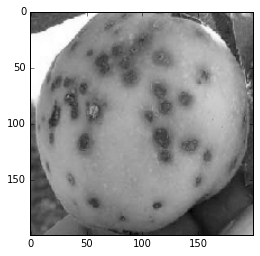

In [88]:
i=10
folder = 'scab'
plt.imshow(np.reshape(imgPixelData[folder][i], (200,200)),cmap = 'gray')

In [91]:
#Preparing Train and test data

classes = [('normal',0),('scab',1),('rot',1),('blotch',1)] # Can add multiple folders to the same class for one-vs-all classification

imgData = []
imgLabel = []

for folder in classes:
    
    for i in range(80):
        imgData.append(imgPixelData[folder[0]][i])
        imgLabel.append(folder[1])

### Logistic Regression Model

In [153]:

import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def likelihood(pred,labels):
    '''Calculates log likelihood function'''
    
    logpred = np.array([math.log(i) for i in pred])
    
    return(-np.mean(labels*logpred + (1-labels)*(1-logpred)))

def accuracy(pred,label):
    '''Calculates accuracy metric'''
    
    out = [1 if x[0]==x[1] else 0 for x in zip(pred,label) ]
    
    return(sum(out)/float(len(pred)))


def predict(weight, data):
    '''
    Given input data and weights, outputs binary classification prediction
    '''
    
    if isinstance(data,list):
        y_pred = np.array([sigmoid(x) for x in np.matmul(data,weight)])

        output = np.array([1 if x>= 0.5 else 0 for x in y_pred ])

        return(output)
    else:
        y_pred = sigmoid(np.matmul(data,weight))
        
        output = 1 if y_pred>=0.5 else 0
        
        return(output)


def calcMetric(pred, label):
    '''Calculates accuracy, precision, recall and f1 score for given set of predictions and labels'''

    
    totalSize = len(pred)
    
    accList = [1 if x[0]==x[1] else 0 for x in zip(pred,label) ]    
    accuracy = sum(accList)/float(totalSize)
    
    true_positive = float(np.sum([1 if (x[0]==1 and x[1]==1) else 0 for x in zip(pred,label)]))
    true_negative = float(np.sum([1 if (x[0]==0 and x[1]==0) else 0 for x in zip(pred,label)]))
    
    false_positive = float(np.sum([1 if (x[0]==1 and x[1]==0) else 0 for x in zip(pred,label)]))
    false_negative = float(np.sum([1 if (x[0]==0 and x[1]==1) else 0 for x in zip(pred,label)]))
    
    if (true_positive+false_positive) != 0:
        precision = true_positive/(true_positive + false_positive)
    else:
        precision = 0
        
    if (true_positive + false_negative)!=0:
        recall = true_positive/(true_positive + false_negative)
    else:
        recall = 0
    
    if recall==0 or precision ==0:
        f1 =0
    else:
        f1 = 2/((1/precision) + (1/recall))

    
    return([accuracy,precision, recall, f1])

def shuffleData(data,label):
    '''
    Shuffles the data so that all digits are not stacked sequentially
    '''
    
    zipData = [i for i in zip(data,label)]
    random.shuffle(zipData)
    
    data = [np.array(i[0]) for i in zipData]
    label = [i[1] for i in zipData]
    
    return([data,label])

In [96]:
imgData,imgLabel  = shuffleData(imgData,imgLabel)

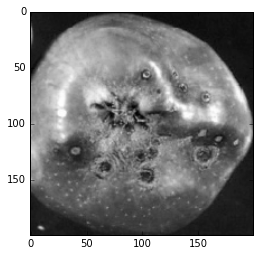

In [105]:
i = 7
plt.imshow(np.reshape(imgData[i],(200,200)),cmap='gray')

In [180]:
def train(data,label,learningRate = 0.001, nEpochs = 10, batchSize =10,verbose=False,returnBestModel = True):
    '''
    Trains a logistic regression for the given hyperparameters
    
    ARGUMENTS
    
    data : Training image data
    label : Labels for training data
    nEpochs : No of training iterations
    batchSize :Size of batch taken for training. Should be a divisor of the length of the training data
    verbose : Logical variable to print the performance metrics for intermediate rounds
    returnBestModel : Logical variable which decides whether the best model is returned or the latest model
    
    
    '''
    bestModel = 0
    bestMetric = [0,0,0,0]
    
    W = np.random.uniform(low = -np.sqrt(6.0/(40000 + 1)), high = np.sqrt(6.0/(40000+ 1)), size= (40000,))
    
    for i in range(nEpochs):
        
        for batch in range(0,len(data),batchSize):
            
            batchData = np.array(data[batch:(batch+batchSize)])
            batchLabel = np.array(label[batch:(batch+batchSize)])
            
            y_pred = np.array([sigmoid(x) for x in np.matmul(batchData,W)])
            
            cost = likelihood(y_pred,batchLabel)
            
            for wgt in range(len(W)):
                inputSlice = batchData[:,wgt]
                error = batchLabel - y_pred

                derivative = np.sum(inputSlice*error)
                W[wgt] = W[wgt] + learningRate*derivative
                
        prediction = predict(data=data,weight=W)
        metrics = calcMetric(pred=prediction,label=label)
        
        if metrics[0]>bestMetric[0]:
            bestModel = W
            bestMetric = metrics
            
        if verbose == True:
            print("iteration : %d accuracy : %f precision : %f recall : %f f1 : %f"%(i,metrics[0],metrics[1],metrics[2],metrics[3]))
        
    print("Best model accuracy : %f precision : %f recall : %f f1 : %f"%(bestMetric[0],bestMetric[1],bestMetric[2],bestMetric[3]))
    
    if returnBestModel == True:
        return(bestModel)
    else:
        return(W)
        
        
                

In [137]:
#Train a single model
W = train(imgData,imgLabel,nEpochs =5,verbose = True)

iteration : 0 accuracy : 0.775000 precision : 0.770968 recall : 0.995833 f1 : 0.869091
iteration : 1 accuracy : 0.800000 precision : 0.791391 recall : 0.995833 f1 : 0.881919
iteration : 2 accuracy : 0.825000 precision : 0.812925 recall : 0.995833 f1 : 0.895131
iteration : 3 accuracy : 0.853125 precision : 0.838596 recall : 0.995833 f1 : 0.910476
iteration : 4 accuracy : 0.859375 precision : 0.844523 recall : 0.995833 f1 : 0.913958
Best model accuracy : 0.000000 precision : 0.000000 recall : 0.000000 f1 : 0.000000


Correct. True Label : 0 Pred Label: 0


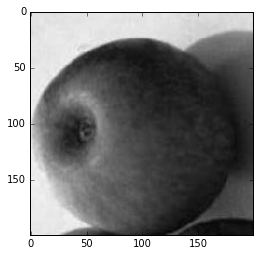

In [168]:
#Visualizing the output
i = 33
img = imgData[i]
label = imgLabel[i]
pred = predict(data=img,weight=W)
result = "Correct" if label==pred else "Incorrect"

print(result+". True Label : "+str(label)+" Pred Label: "+str(pred))

plt.imshow(np.reshape(img,(200,200)),cmap='gray')

### Cross Validation

The below cell executes one run of k-fold CV. The cell can be run multiple times to execute multiple runs of k-fold CV

In [ ]:
#CV Parameters
numFolds = 10
learningRate = 0.001
nEpochs = 2
batchSize = 16


#Splitting data into folds
cvFolds = {}

for i in range(numFolds):
    cvFolds[i]=[]

imgData,imgLabel  = shuffleData(imgData,imgLabel)


for i in range(len(imgData)):
    key = i%numFolds
    cvFolds[key].append((imgData[i],imgLabel[i]))
    
#-------------------------------------------------------------------------------------------#    

cvMetrics = []

# Carrying out CV
for i in range(numFolds):
    
    trainData=[]
    trainLabel=[]
    testData=[]
    testLabel=[]
    
    #Filling train/test data
    for fold in range(numFolds):
        
        if fold == i:        #test dataset
            for obs in cvFolds[fold]:
                testData.append(obs[0])
                testLabel.append(obs[1])
        else:
            for obs in cvFolds[fold]:   #train dataset
                trainData.append(obs[0])
                trainLabel.append(obs[1])
                
    W = train(trainData,trainLabel,batchSize=batchSize,learningRate=learningRate,
              nEpochs=nEpochs,verbose=True,returnBestModel=False)
    
    trainPred = predict(data=trainData,weight=W)
    testPred = predict(data=testData,weight=W)
    trainMetrics = calcMetric(pred=trainPred,label=trainLabel)
    testMetrics = calcMetric(pred=testPred,label=testLabel)
    cvMetrics.append(testMetrics)
    
    print("CV FOLD : %d"%i)
    print("Train accuracy : %f precision : %f recall : %f f1 : %f"%(trainMetrics[0],trainMetrics[1],trainMetrics[2],trainMetrics[3]))
    print("Test accuracy : %f precision : %f recall : %f f1 : %f"%(testMetrics[0],testMetrics[1],testMetrics[2],testMetrics[3]))
    


#Printing final CV results
                
cvMetrics = np.array(cvMetrics)
print("CV Results")
print("Average accuracy : %f"%np.mean(cvMetrics[:,0]))
print("Average precision : %f"%np.mean(cvMetrics[:,1]))
print("Average recall : %f"%np.mean(cvMetrics[:,2]))
print("Average f1 : %f"%np.mean(cvMetrics[:,3]))